# CatBoost: Multi-class Classification - Rotten Tomatoes Fresh Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # or any classifier
import warnings
import math
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb
warnings.filterwarnings('ignore')

In [ ]:
!pip install feature-engine

In [ ]:
!pip install catboost

In [ ]:
from catboost import Pool, CatBoostClassifier
from catboost.datasets import rotten_tomatoes

In [ ]:
df_train, df_test = rotten_tomatoes()
print(df_train.shape)
print(df_test.shape)

(32712, 22)
(8179, 22)


In [ ]:
df_train.head(2)

,id,synopsis,rating_MPAA,genre,director,writer,theater_date,dvd_date,box_office,runtime,...,theater_date_int,review,rating,fresh,critic,top_critic,publisher,date,date_int,rating_10
0,830.0,A gay New Yorker stages a marriage of convenie...,R,Art House and International | Comedy | Drama |...,Ang Lee,Ang Lee | James Schamus | Neil Peng,1993-08-04,2004-06-15,NaN,111.0,...,19930804,NaN,0.800000,fresh,Carol Cling,0,Las Vegas Review-Journal,2004-04-16,20040416.0,8.0
1,1161.0,Screenwriter Nimrod Antal makes an impressive ...,R,Action and Adventure | Art House and Internati...,NaN,NaN,2005-04-01,2005-08-30,116783.0,105.0,...,20050401,"One very long, dark ride.",0.647059,rotten,NaN,0,E! Online,2005-04-22,20050422.0,6.0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32712 entries, 0 to 32711
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                32712 non-null  float64
 1   synopsis          32628 non-null  object 
 2   rating_MPAA       32654 non-null  object 
 3   genre             32654 non-null  object 
 4   director          29334 non-null  object 
 5   writer            27083 non-null  object 
 6   theater_date      32012 non-null  object 
 7   dvd_date          32012 non-null  object 
 8   box_office        20430 non-null  float64
 9   runtime           32217 non-null  float64
 10  studio            24018 non-null  object 
 11  dvd_date_int      32712 non-null  int64  
 12  theater_date_int  32712 non-null  int64  
 13  review            28273 non-null  object 
 14  rating            32712 non-null  float64
 15  fresh             32712 non-null  object 
 16  critic            31123 non-null  object

In [ ]:
df_train = df_train.dropna(subset = ['genre', 'synopsis', 'review'])
df_test = df_test.dropna(subset = ['genre', 'synopsis', 'review'])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)

(28204, 22)
(7068, 22)


# EDA

In [ ]:
df_train['fresh'].value_counts(normalize=True)

,proportion
fresh,
fresh,0.614523
rotten,0.385477


In [ ]:
df_train['rating'].describe(percentiles=np.linspace(0, 1, 11))

,rating
count,28204.000000
mean,0.639577
std,0.209621
min,0.000000
0%,0.000000
10%,0.375000
20%,0.500000
30%,0.500000
40%,0.600000
50%,0.625000


In [ ]:
df_test['rating'].describe(percentiles=np.linspace(0, 1, 11))

,rating
count,7068.000000
mean,0.636615
std,0.211740
min,0.000000
0%,0.000000
10%,0.375000
20%,0.500000
30%,0.500000
40%,0.600000
50%,0.625000


# Data Cleaning

In [ ]:
def create_fresh_class(x):
    if x > 0.75:
        return 'fresh'
    elif x > 0.5:
        return 'mid'
    else:
        return 'rotten'

df_train['target'] = df_train['rating'].apply(create_fresh_class)
df_test['target'] = df_test['rating'].apply(create_fresh_class)

In [ ]:
df_train['target'].value_counts(normalize=True)

,proportion
target,
mid,0.386257
fresh,0.311268
rotten,0.302475


In [ ]:
df_test['target'].value_counts(normalize=True)

,proportion
target,
mid,0.386672
rotten,0.306876
fresh,0.306452


# Data Preparation & Analysis

In [ ]:
import pandas as pd
from collections import Counter
import re

def get_genre_counts(df: pd.DataFrame) -> Counter:
    """
    Compute frequency counts of unique genres from a DataFrame with a 'genres' column.
    """
    all_genres = []

    for val in df['genre'].dropna():
        # Split on '|' and strip spaces around each genre
        parts = re.split(r"\s*\|\s*", val)
        all_genres.extend(parts)

    genre_counts = Counter(all_genres)
    return genre_counts.most_common()

In [ ]:
genre_counts_train = get_genre_counts(df_train)
genre_counts_train

[('Drama', 17215),
 ('Comedy', 11149),
 ('Action and Adventure', 6849),
 ('Mystery and Suspense', 6043),
 ('Romance', 4254),
 ('Science Fiction and Fantasy', 3883),
 ('Kids and Family', 2536),
 ('Horror', 2215),
 ('Art House and International', 2124),
 ('Animation', 1574),
 ('Musical and Performing Arts', 1009),
 ('Classics', 886),
 ('Western', 616),
 ('Documentary', 613),
 ('Special Interest', 464),
 ('Sports and Fitness', 221),
 ('Television', 111),
 ('Faith and Spirituality', 100),
 ('Cult Movies', 19),
 ('Anime and Manga', 16),
 ('Gay and Lesbian', 10)]

In [ ]:
genre_counts_test = get_genre_counts(df_test)
genre_counts_test

[('Drama', 4329),
 ('Comedy', 2766),
 ('Action and Adventure', 1648),
 ('Mystery and Suspense', 1506),
 ('Romance', 1040),
 ('Science Fiction and Fantasy', 952),
 ('Kids and Family', 646),
 ('Horror', 588),
 ('Art House and International', 532),
 ('Animation', 390),
 ('Musical and Performing Arts', 282),
 ('Classics', 220),
 ('Western', 155),
 ('Documentary', 135),
 ('Special Interest', 104),
 ('Sports and Fitness', 66),
 ('Faith and Spirituality', 25),
 ('Television', 23),
 ('Gay and Lesbian', 7),
 ('Anime and Manga', 5),
 ('Cult Movies', 2)]

In [ ]:
print(len(genre_counts_train))
print(len(genre_counts_test))

21
21


In [ ]:
df_train.loc[6, 'synopsis']

'Alfie Elkins is a philosophical womanizer who is forced to question his seemingly carefree existence. Ultimately, his freewheeling lifestyle begins to slowly unravel.'

In [ ]:
df_train.loc[6, 'review']

"Alfie no longer has its bite. Sure, there's plenty of bad behavior, but Jude Law's Alfie is, as scoundrels go, a pretty nice guy."

In [ ]:
df_train['box_office'].describe(percentiles=np.linspace(0,1,11)).round(0)

,box_office
count,19505.0
mean,54445524.0
std,69933321.0
min,363.0
0%,363.0
10%,1149350.0
20%,4436352.0
30%,10928042.0
40%,16302332.0
50%,27696504.0


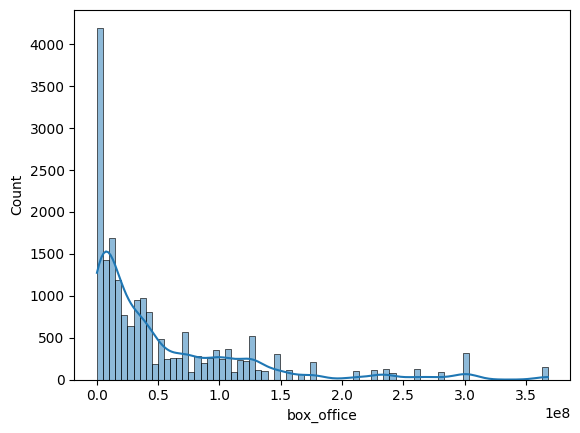

In [ ]:
sns.histplot(df_train['box_office'], kde=True);

# Feature Engineering

* genre (CountVectorizer)
* box_office
* synopsis (embedding feature)
* top_critic (binary)
* review (text feature) (v2)

In [ ]:
df_train['target'] = df_train['target'].map({'fresh': 2, 'mid': 1, 'rotten': 0})
df_test['target'] = df_test['target'].map({'fresh': 2, 'mid': 1, 'rotten': 0})

In [ ]:
X_cols = ['genre', 'box_office', 'synopsis', 'top_critic', 'review']
y_col = 'target'

X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[y_col]
y_test = df_test[y_col]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28204, 5)
(7068, 5)
(28204,)
(7068,)


In [ ]:
# X_train['genre_list'] = df_train["genre"].str.split(r"\s*\|\s*")
# X_test['genre_list'] = df_test["genre"].str.split(r"\s*\|\s*")

In [ ]:
# X_train.head()

In [ ]:
# genre_vec = CountVectorizer(
#     tokenizer=lambda x: x,       # x is already a list of tokens
#     preprocessor=lambda x: x,    # don’t touch the input
#     lowercase=False,             # keep genre case as-is
#     binary=True,                 # multi-hot (presence/absence)
#     min_df=2                     # drop very rare genres (tune this)
# )

In [ ]:
# genre_vec.fit(X_train['genre_list'])

In [ ]:
# X_train_genre = pd.DataFrame(genre_vec.transform(X_train['genre_list']).toarray(), columns=genre_vec.get_feature_names_out())
# X_test_genre = pd.DataFrame(genre_vec.transform(X_test['genre_list']).toarray(), columns=genre_vec.get_feature_names_out())

In [ ]:
# X_train_genre

# Feature Engineering Function

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from feature_engine import imputation as mdi
from sklearn.preprocessing import StandardScaler
from feature_engine.transformation import BoxCoxTransformer
from sentence_transformers import SentenceTransformer
import time


def prepare_genre_features(X_train, X_test):
  # tokenize genres
  X_train['genre_list'] = X_train['genre'].str.split(r"\s*\|\s*")
  X_test['genre_list'] = X_test['genre'].str.split(r"\s*\|\s*")

  # CountVectorizer for genres
  genre_vectorizer = CountVectorizer(
    tokenizer=lambda x: x,       # x is already a list of tokens
    preprocessor=lambda x: x,    # don’t touch the input
    lowercase=False,             # keep genre case as-is
    binary=True,                 # multi-hot (presence/absence)
    min_df=2                     # drop very rare genres (tune this)
    )

  # # fit/transform vectorizer
  genre_vectorizer.fit(X_train['genre_list'])
  X_train_genre = pd.DataFrame(genre_vectorizer.transform(X_train['genre_list']).toarray(), columns=genre_vectorizer.get_feature_names_out())
  X_test_genre = pd.DataFrame(genre_vectorizer.transform(X_test['genre_list']).toarray(), columns=genre_vectorizer.get_feature_names_out())

  box_office_pipeline = Pipeline([
      ('imputer_num', mdi.MeanMedianImputer(imputation_method='median', variables=['box_office'])),
      ('bct', BoxCoxTransformer(variables=['box_office'])),
  ])

  # transform box office data
  box_office_pipeline.fit(X_train)
  X_train = box_office_pipeline.transform(X_train)
  X_test = box_office_pipeline.transform(X_test)


  # embedding model
  model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
  train_text = X_train['synopsis'].tolist()
  test_text = X_test['synopsis'].tolist()

  # generating embeddings
  start = time.time()
  print(f'Generating X_train embeddings: {len(train_text)}')
  train_embeddings = model.encode(train_text, batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
  elapsed = time.time() - start
  mins, secs = divmod(elapsed, 60)
  print(f"Generating X_train in {int(mins)} min {secs:.2f} sec.")

  start = time.time()
  print(f'Generating X_test embeddings: {len(test_text)}')
  test_embeddings = model.encode(test_text, batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
  elapsed = time.time() - start
  mins, secs = divmod(elapsed, 60)
  print(f"Generating X_train in {int(mins)} min {secs:.2f} sec.")

  X_train_synopsis = pd.DataFrame({"synopsis_embedding": list(train_embeddings)})
  X_test_synopsis = pd.DataFrame({"synopsis_embedding": list(test_embeddings)})

  # concatenate all features
  X_train = pd.concat([X_train, X_train_genre, X_train_synopsis], axis=1)
  X_test = pd.concat([X_test, X_test_genre, X_test_synopsis], axis=1)

  # drop transformed cols
  cols_to_drop = ['genre', 'genre_list', 'synopsis']
  X_train = X_train.drop(cols_to_drop, axis=1)
  X_test = X_test.drop(cols_to_drop, axis=1)

  return X_train, X_test

In [ ]:
# X_train_transformed, X_test_transformed = prepare_genre_features(X_train, X_test)

# print(X_train_transformed.shape)
# print(X_test_transformed.shape)

In [ ]:
train_path = '/content/drive/MyDrive/Colab/Machine Learning/GBM Implementations/X_train_transformed.csv'
# X_train_transformed.to_csv(train_path, index=False)

In [ ]:
test_path = '/content/drive/MyDrive/Colab/Machine Learning/GBM Implementations/X_test_transformed.csv'
# X_test_transformed.to_csv(test_path, index=False)

---

# Model Fitting

In [ ]:
# read training data
X_train_transformed = pd.read_csv(train_path)
X_test_transformed = pd.read_csv(test_path)

print(X_train_transformed.shape)
print(X_test_transformed.shape)

(28204, 25)
(7068, 25)


In [ ]:
X_test_transformed.loc[0, "synopsis_embedding"]

'[-1.03309430e-01 -6.75572157e-02 -4.29820009e-02 -5.49041331e-02\n  4.61905301e-02  1.97085720e-02  3.78773548e-02  7.09962249e-02\n -2.25849934e-02  4.28340062e-02  7.01062521e-03 -9.75680724e-03\n -6.75242441e-03  6.29267022e-02 -9.86223482e-03  1.51309837e-02\n  6.12204522e-02  3.50045003e-02 -1.05263889e-02  5.83091900e-02\n -5.21242619e-02 -3.96934431e-03 -1.81223582e-02 -1.28831835e-02\n -8.68262723e-02  1.81075018e-02  5.92741221e-02  1.51025914e-02\n -7.12024570e-02 -8.49832669e-02  7.32924882e-03  9.65718587e-04\n -8.65122974e-02  1.73156671e-02  1.44311255e-02 -4.54632267e-02\n -1.93904098e-02  6.46511316e-02  2.60991491e-02 -3.11508812e-02\n  4.59973961e-02 -5.54966182e-02 -1.58622535e-03 -1.41224572e-02\n  6.58306181e-02 -1.05657861e-01  5.88472635e-02  5.53940535e-02\n  6.53958321e-02 -5.42154014e-02  1.93853416e-02  7.24221999e-03\n  8.27982947e-02  1.19184153e-02  6.41095266e-02  3.58811542e-02\n  3.05838250e-02  3.81888705e-03  2.24845856e-02 -3.34403734e-03\n  2.36317

In [ ]:
# properly format embeddings, currently list of floats not comma separated
EMB_COL  = "synopsis_embedding"

def parse_embedding(x):
    # Handle both str and already-list
    if isinstance(x, str):
        # strip brackets and parse floats separated by space
        return np.fromstring(x.strip("[]"), sep=" ").astype(float).tolist()
    elif isinstance(x, np.ndarray):
        return x.astype(float).tolist()
    else:
        return list(map(float, x))

# Clean embeddings into list[float]
# X_train_fixed = X_train_transformed.copy()
# X_test_fixed  = X_test_transformed.copy()
X_train_transformed[EMB_COL] = X_train_transformed[EMB_COL].apply(parse_embedding)
X_test_transformed[EMB_COL]  = X_test_transformed[EMB_COL].apply(parse_embedding)

In [ ]:
X_test_transformed.loc[0, EMB_COL][:5]

[-0.10330943, -0.0675572157, -0.0429820009, -0.0549041331, 0.0461905301]

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

text_features = ['review']
embedding_features = ['synopsis_embedding']

X_train_transformed_baseline = X_train_transformed.drop(['review', 'synopsis_embedding'], axis=1)
X_test_transformed_baseline = X_test_transformed.drop(['review', 'synopsis_embedding'], axis=1)

X_train_transformed_embedding = X_train_transformed.drop(['review'], axis=1)
X_test_transformed_embedding = X_test_transformed.drop(['review'], axis=1)


# dataset with just numeric features, excluding text and embeddings
train_pool_baseline = Pool(data=X_train_transformed_baseline,
                  label=y_train,
                  # text_features=text_features,
                  # embedding_features=embedding_features,
                  feature_names = list(X_train_transformed_baseline.columns))

test_pool_baseline = Pool(data=X_test_transformed_baseline,
                 label=y_test,
                #  text_features=text_features,
                #  embedding_features=embedding_features,
                 feature_names = list(X_test_transformed_baseline.columns))

# dataset with numeric features and embedding feature
train_pool_embedding = Pool(data=X_train_transformed_embedding,
                  label=y_train,
                  # text_features=text_features,
                  embedding_features=embedding_features,
                  feature_names = list(X_train_transformed_embedding.columns))

test_pool_embedding = Pool(data=X_test_transformed_embedding,
                 label=y_test,
                #  text_features=text_features,
                 embedding_features=embedding_features,
                 feature_names = list(X_test_transformed_embedding.columns))


# dataset with numeric features + embedding feature + text features
train_pool = Pool(data=X_train_transformed,
                  label=y_train,
                  text_features=text_features,
                  embedding_features=embedding_features,
                  feature_names = list(X_train_transformed.columns))

test_pool = Pool(data=X_test_transformed,
                 label=y_test,
                 text_features=text_features,
                 embedding_features=embedding_features,
                 feature_names = list(X_test_transformed.columns))


params = {
    "loss_function": "MultiClass",
    "eval_metric": "TotalF1", #https://catboost.ai/docs/en/references/custom-metric__supported-metrics
    "iterations": 1000,
    "learning_rate": 0.03,
    "depth": 4,
    "random_seed": 42,
    "verbose": 100
}

In [ ]:
# baseline model
model = CatBoostClassifier(**params)
model.fit(train_pool_baseline, eval_set=test_pool_baseline, use_best_model=True)

0:	learn: 0.3897969	test: 0.3908021	best: 0.3908021 (0)	total: 10.3ms	remaining: 10.3s
100:	learn: 0.4512409	test: 0.4489294	best: 0.4505951 (98)	total: 940ms	remaining: 8.36s
200:	learn: 0.4618650	test: 0.4546728	best: 0.4548792 (193)	total: 1.85s	remaining: 7.35s
300:	learn: 0.4764606	test: 0.4644033	best: 0.4644033 (300)	total: 2.78s	remaining: 6.45s
400:	learn: 0.4877853	test: 0.4771403	best: 0.4787386 (386)	total: 3.68s	remaining: 5.49s
500:	learn: 0.5074834	test: 0.4955326	best: 0.4955326 (499)	total: 4.59s	remaining: 4.58s
600:	learn: 0.5184027	test: 0.5075040	best: 0.5079434 (593)	total: 5.51s	remaining: 3.66s
700:	learn: 0.5236823	test: 0.5134486	best: 0.5142590 (681)	total: 6.61s	remaining: 2.82s
800:	learn: 0.5260260	test: 0.5152848	best: 0.5159338 (778)	total: 8.62s	remaining: 2.14s
900:	learn: 0.5345097	test: 0.5223502	best: 0.5223502 (900)	total: 10.3s	remaining: 1.13s
999:	learn: 0.5364172	test: 0.5240484	best: 0.5246431 (953)	total: 11.2s	remaining: 0us

bestTest = 0.52

In [ ]:
# baseline + embedding feature
model = CatBoostClassifier(**params)
model.fit(train_pool_embedding, eval_set=test_pool_embedding, use_best_model=True)

0:	learn: 0.4652244	test: 0.4691576	best: 0.4691576 (0)	total: 12.2ms	remaining: 12.2s
100:	learn: 0.4973427	test: 0.5053840	best: 0.5062722 (95)	total: 1.14s	remaining: 10.1s
200:	learn: 0.5099811	test: 0.5111816	best: 0.5111967 (197)	total: 2.14s	remaining: 8.52s
300:	learn: 0.5191046	test: 0.5218023	best: 0.5223316 (296)	total: 3.36s	remaining: 7.8s
400:	learn: 0.5263595	test: 0.5276523	best: 0.5279233 (390)	total: 5.84s	remaining: 8.73s
500:	learn: 0.5306781	test: 0.5269663	best: 0.5285405 (479)	total: 7.18s	remaining: 7.15s
600:	learn: 0.5377182	test: 0.5313906	best: 0.5337665 (589)	total: 8.2s	remaining: 5.45s
700:	learn: 0.5424088	test: 0.5321098	best: 0.5338693 (608)	total: 9.24s	remaining: 3.94s
800:	learn: 0.5441355	test: 0.5353117	best: 0.5359418 (797)	total: 10.3s	remaining: 2.55s
900:	learn: 0.5486292	test: 0.5393949	best: 0.5393949 (900)	total: 11.3s	remaining: 1.24s
999:	learn: 0.5514351	test: 0.5408421	best: 0.5409529 (988)	total: 12.3s	remaining: 0us

bestTest = 0.5409

In [ ]:
# baseline + embedding feature + text features
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

0:	learn: 0.5200930	test: 0.5480864	best: 0.5480864 (0)	total: 348ms	remaining: 5m 47s
100:	learn: 0.5529600	test: 0.5866756	best: 0.5868417 (98)	total: 32.1s	remaining: 4m 45s
200:	learn: 0.5577292	test: 0.5919773	best: 0.5922386 (199)	total: 59.9s	remaining: 3m 58s
300:	learn: 0.5619847	test: 0.5940546	best: 0.5944805 (295)	total: 1m 26s	remaining: 3m 21s
400:	learn: 0.5668073	test: 0.5951192	best: 0.5955883 (362)	total: 1m 53s	remaining: 2m 49s
500:	learn: 0.5713295	test: 0.5974431	best: 0.5977099 (482)	total: 2m 20s	remaining: 2m 19s
600:	learn: 0.5751177	test: 0.5974794	best: 0.5987556 (557)	total: 2m 46s	remaining: 1m 50s
700:	learn: 0.5774893	test: 0.5987777	best: 0.5990764 (690)	total: 3m 12s	remaining: 1m 22s
800:	learn: 0.5807069	test: 0.5986914	best: 0.5996139 (726)	total: 3m 37s	remaining: 54s
900:	learn: 0.5828735	test: 0.5990787	best: 0.5996139 (726)	total: 4m 3s	remaining: 26.8s
999:	learn: 0.5850509	test: 0.6010770	best: 0.6010770 (999)	total: 4m 29s	remaining: 0us

bes

In [ ]:
y_pred = model.predict(test_pool).ravel()
y_pred_proba = model.predict_proba(test_pool)
# print("log_loss:", log_loss(y_test, proba, labels=[0, 1, 2]))

In [ ]:
y_pred

array([2, 1, 1, ..., 0, 2, 0])

In [ ]:
y_pred_proba

array([[0.05098562, 0.34397674, 0.60503764],
       [0.21563039, 0.60671962, 0.17764998],
       [0.13603465, 0.66344538, 0.20051998],
       ...,
       [0.8091519 , 0.16047648, 0.03037162],
       [0.05746464, 0.21142832, 0.73110704],
       [0.58095464, 0.35286427, 0.06618109]])

# Evaluation Metrics

In [ ]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_multiclass(y_true, y_pred, labels=None, class_names=None, digits=3):
    """
    Evaluate multi-class classification results with various metrics and plots.

    Parameters
    ----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    labels : list, optional
        List of labels to include in evaluation. If None, inferred from data.
    class_names : list, optional
        Class names for the confusion matrix. Defaults to labels.
    digits : int
        Number of decimals for reporting
    """

    # ======================
    # Summary metrics
    # ======================
    print("\n=== Summary Metrics ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.{digits}f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.{digits}f}")
    print(f"Precision (Macro): {precision_score(y_true, y_pred, average='macro'):.{digits}f}")
    print(f"Recall (Macro): {recall_score(y_true, y_pred, average='macro'):.{digits}f}")
    print(f"F1 (Macro): {f1_score(y_true, y_pred, average='macro'):.{digits}f}")

    # ======================
    # Confusion Matrix
    # ======================
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", cbar=False,
        xticklabels=class_names if class_names is not None else labels,
        yticklabels=class_names if class_names is not None else labels
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ======================
    # Detailed Report
    # ======================
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, labels=labels, digits=digits))

    # ======================
    # Averaged Metrics
    # ======================
    print("\n=== Average Metrics (Macro, Weighted, Micro) ===")
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average="weighted"
    )

    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average="micro"
    )

    print(f"Precision (Macro): {precision_score(y_true, y_pred, average='macro'):.{digits}f}")
    print(f"Precision (Weighted): {precision_weighted:.{digits}f}")
    print(f"Precision (Micro): {precision_micro:.{digits}f}")
    print(f"Recall (Macro): {recall_score(y_true, y_pred, average='macro'):.{digits}f}")
    print(f"Recall (Weighted): {recall_weighted:.{digits}f}")
    print(f"Recall (Micro): {recall_micro:.{digits}f}")
    print(f"F1 (Macro): {f1_score(y_true, y_pred, average='macro'):.{digits}f}")
    print(f"F1 (Weighted): {f1_weighted:.{digits}f}")
    print(f"F1 (Micro): {f1_micro:.{digits}f}")


=== Summary Metrics ===
Accuracy: 0.600
Balanced Accuracy: 0.605
Precision (Macro): 0.608
Recall (Macro): 0.605
F1 (Macro): 0.606


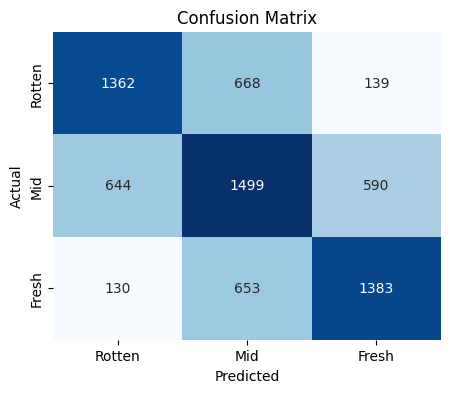


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.638     0.628     0.633      2169
           1      0.532     0.548     0.540      2733
           2      0.655     0.639     0.647      2166

    accuracy                          0.600      7068
   macro avg      0.608     0.605     0.606      7068
weighted avg      0.602     0.600     0.601      7068


=== Average Metrics (Macro, Weighted, Micro) ===
Precision (Macro): 0.608
Precision (Weighted): 0.602
Precision (Micro): 0.600
Recall (Macro): 0.605
Recall (Weighted): 0.600
Recall (Micro): 0.600
F1 (Macro): 0.606
F1 (Weighted): 0.601
F1 (Micro): 0.600


In [ ]:
# Example usage (replace with your classifier output)
evaluate_multiclass(
    y_true=y_test,
    y_pred=y_pred,
    labels=[0,1,2],  # optional, your label set
    class_names=["Rotten", "Mid", "Fresh"]  # optional
)

In [ ]:
res = model.calc_feature_statistics(data=train_pool,
                                    target=y_test,
                                    feature=0,
                                    plot=True)